## A Deep_iSith model that trains on EEG data.
YW  
Grasp-and-Lift EEG Detection  
https://www.kaggle.com/c/grasp-and-lift-eeg-detection/data  
For now, only consider one subject and one trial at a time
Use all event channels, and no preprocessing is performed.  
Only teh first 10000 time points and all 32 channels are used.
CPU for now, will transfer to Rivanna with GPU


In [178]:
# preprocessing
import mne
import numpy as np
import math
import pandas as pd
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

# pytorch
import torch
import torch.nn
import torch.nn.functional as F
ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
print(ttype)
# deep_iSITH is being used here, not deep_sith
from sith import iSITH
import matplotlib.pyplot as plt
%matplotlib inline

# training 
from torch import nn as nn
from math import factorial
import random
import seaborn as sn
import os 
from os.path import join
import glob


# deep_iSITH is being used here, not deep_sith
from sith import DeepSITH
from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")

<class 'torch.DoubleTensor'>


## A useful funciton to read the csv data and save to a mne raw file

In [55]:

def creat_mne_raw_object(fname,read_events=True):
    """
    obtained from @author: alexandrebarachant
    https://www.kaggle.com/alexandrebarachant/beat-the-benchmark-0-67
    Create a mne raw instance from csv file.
    Make sure the events and data files are in the same folder
    data are transformed into microvolts
    """
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    #montage = make_standard_montage('standard_1005')

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
        
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)
    #info['filename'] = fname
    print(info)
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    #print(data)
    return raw

## plot and testing


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG, 6 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 38
 projs: []
 sfreq: 500.0 Hz
>
34 events found
Event IDs: [1]


<ipython-input-55-29a39170704c>:35: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)


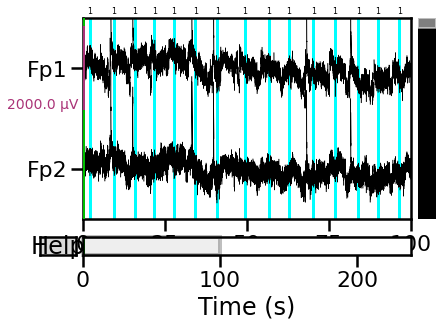

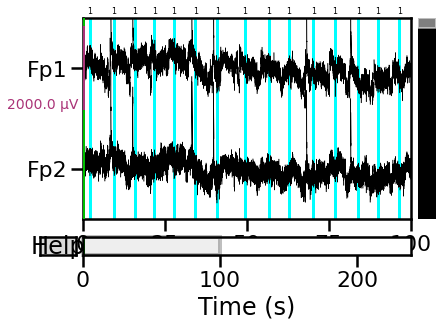

In [56]:
# testing
raw = creat_mne_raw_object("grasp-and-lift-eeg-detection/train/subj1_series1_data.csv")
# plotting 
# scaling is necessary to show the graphs properly
# vertical lines indicate a event
scalings = {'eeg': 10e-4}
events = mne.find_events(raw, stim_channel=['HandStart',])
raw.plot(n_channels=2,scalings=scalings,duration=100.0, events= events)

## Prepare the data for training and testing
A fairly simple toy model: try to predict all events.   
    The **input** signal needs to be in correct format: **[nbatch x 1 x nfeutures x time]** pytorch tensor.
    The inputs to the models are the time series EEG signals. All channels will be
    concatnated into one channel by iSith.    
    The **targets** are inputed separately with **[nClasses x time]**  tensor. The target is either 0 or 1 at any time point for each event channel. Needs to relabel them into $nClasses \in \{1,2 ... ,K\}$.     
    **Note: Dimention of the input tensors  (batch, MAGIC, features, sequence). The second "magic" dimention will always be 1 in order for this to quickly calculate the output of the SITH layer.**     
    For this model batch should be one because we only feed one trial of one subject.    

In [213]:

# input data, for this toy model, only consider the first 10000 unprocessed time points
## channels 32 to 38 are targets, for this model.

data_length = 10000
nClass = 6
data = raw.get_data()[:,0:data_length]
input_signal = data[0:32,:]
print(input_signal.shape)
target_signal = data[32:,:] # use 1 channels
print(target_signal.shape)

(32, 10000)
(6, 10000)


## Reformat the target

In [216]:
# Assume each event channel is orthogonal
# combine each channel into one channel with one numer indicates its class, zero mean no event
for i in range(target_signal.shape[0]):
    target_signal[i,:][target_signal[i,:] == 1] = i+1
target_signal = np.sum(target_signal, axis=0)
# anything larger than 6 should not happen, assign to zero
target_signal[target_signal>6] =0
print(target_signal.shape)

(10000,)


In [218]:
np.max(target_signal)

6.0

## Reformat the data into pytorch tensors

In [219]:
# reformatt into tensor
input_tensor = ttype(input_signal.reshape(1,1,input_signal.shape[0],-1))
target_tensor = ttype(target_signal.reshape(-1))

print(input_tensor.shape, target_tensor.shape)

torch.Size([1, 1, 32, 10000]) torch.Size([10000])


## Random split to training and validation 
(for now, just do first 50% as training and last 50% as validation for simplicity)  
Makes sure to update this funciton later for random partition

In [301]:
cut = 5000
# for now, pick one batch as testing
train_X =  input_tensor[:,:,:,:cut]
train_Y = target_tensor[:cut]
test_X =  input_tensor[:,:,:,cut:]
test_Y = target_tensor[cut:]
print(train_X.shape,train_Y.shape,test_X.shape,test_Y.shape)

torch.Size([1, 1, 32, 5000]) torch.Size([5000]) torch.Size([1, 1, 32, 5000]) torch.Size([5000])


## Define training, testing functions, and Deep_sith models
**Training**:
Currently only use one batch. Will add batch processing ability later.     
**Validation**:   
The performance metric used here is **matthews correlation coeefficient** since the data are imbanlanced.  
Signals need to be in correct format. validation input: [nbatch x 1 x nFeutures x time] tensor.
The validation target has dimension of [time] tensor, in which each entry should be one of the numbers in 
{0,1,2, ... K} at any time point.  

In [259]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, matthews_corrcoef

In [300]:
def train(model, ttype, train_sig, train_ans, 
          test_sig, test_ans, optimizer, loss_func, 
          epoch, loss_buffer_size=4, batch_size=1, 
        prog_bar=None):
    assert(loss_buffer_size%batch_size==0)
    
    loss_track = {"name":[],
                  "loss":[],
                  "acc":[],
                  }
    # make sure tensor types are correct
    train_sig = train_sig.type(torch.DoubleTensor)
    train_ans = train_ans.type(torch.LongTensor)
    
    #--------------------- Training --------------------#
    #currently we only have 1 batch, so no batch processing.
    model.train()
    
    #print(target.shape)
    optimizer.zero_grad()
    
    # make sure the out put is in the right format
    # needs to be in [nbatch x 1 x nfeutures x time]
    # unsqueeze(0) to add back the first dimension if necessary
    ## out = model(sig.unsqueeze(0))
    out = model(train_sig)
    # permute out to the correct format
    out = out[-1,:,:]
    #print(train_ans.shape)
    #print(out.shape)
    loss = loss_func(out, train_ans)
    #print(loss)
    loss.backward()
    optimizer.step()

    
    #--- Record name, loss, validation accuracy --#
    loss_track['name'].append(model.__class__.__name__)
    loss_track['loss'].append(loss.mean().detach().cpu().numpy())
    
    # call test_model for validation accuracy calculations

    acc = test_model(model, test_sig,test_ans)
    loss_track['acc'].append(acc)
       
    # ----  update training progress -------------#
    if  prog_bar is not None:
        # Update progress_bar
        s = "Epoch {},Loss: {:.8f}, Validation Acc{}: "
        format_list = [epoch, loss.mean().detach().cpu().numpy(), acc]         
        s = s.format(*format_list)
        prog_bar.set_description(s)

    return loss_track

def test_model(model, signal,target):
    """
    Test for accuracy
    Iterate through each batch and make prediciton and calculate performance metrics
    Use **matthews correlation coeefficient** since the data are imbanlanced
    Again 
    Signals need to be in correct format. validation input: [nbatch x 1 x nFeutures x time] tensor.

    The target has dimension of [time] tensor, in which each entry should be one of the numbers in 
    {0,1,2, ... K} at any time point.  
    
    """
    matthew =[]
    
    signal = signal.type(torch.DoubleTensor)
    target = target.type(torch.LongTensor)
    #print(targets.shape)
    out = model(signal)
    # permute out to the correct format
    out = out[-1,:,:]
    # pass through a softmax to tansform to probability
    res = torch.nn.functional.softmax(out, dim=1)
    #print(res.shape)
    # find the argmax: assign to the class that has the highest probability
    y_pred = torch.argmax(res, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_true = target.detach().cpu().numpy()
    acc = matthews_corrcoef(y_true = y_true, y_pred = y_pred)

    return acc

## Build a DeepSITH_Tracker based on DeepSITH

In [261]:
from sith import iSITH
class _DeepSITH_core(nn.Module):
    def __init__(self, layer_params):
        super(_DeepSITH_core, self).__init__()

        hidden_size = layer_params.pop('hidden_size', layer_params['in_features'])
        in_features = layer_params.pop('in_features', None)
        batch_norm = layer_params.pop('batch_norm', True)
        act_func = layer_params.pop('act_func', None)
        self.batch_norm = batch_norm
        self.act_func = not (act_func is None)
        self.sith = iSITH(**layer_params)
        
        self.linear = nn.Linear(layer_params['ntau']*in_features,
                                hidden_size)
        nn.init.kaiming_normal_(self.linear.weight.data)
        
        
        if batch_norm:
            self.dense_bn = nn.BatchNorm1d(hidden_size)
        if not (act_func is None):
            self.act_func = act_func
            
    def forward(self, inp):
        # Outputs as : [Batch, features, tau, sequence]
        x = self.sith(inp)
        
        x = x.transpose(3,2).transpose(2,1)
        x = x.view(x.shape[0], x.shape[1], -1)
        x = self.linear(x)
        if self.batch_norm:
            x = x.transpose(2,1)
            x = self.dense_bn(x).transpose(2,1)
        if self.act_func:
            x = self.act_func(x)
        return x


class DeepSITH(nn.Module):
    """A Module built for SITH like an LSTM

    Parameters
    ----------
    layer_params: list
        A list of dictionaries for each layer in the desired DeepSITH. All
        of the parameters needed for the SITH part of the Layers, as well as
        a hidden_size and optional act_func are required to be present.

    layer_params keys
    -----------------
    hidden_size: int (default in_features)
        The size of the output of the hidden layer. Please note that the
        in_features parameter for the next layer's SITH representation should be
        equal to the previous layer's hidden_size. This parameter will default
        to the in_features of the current SITH layer if not specified.
    act_func: torch.nn.Module (default None)
        The torch layer of the desired activation function, or None if no
        there is no desired activation function between layers.

    In addition to these keys, you must include all of the non-optional SITH
    layer keys in each dictionary. Please see the SITH docstring for
    suggestions.

    """
    def __init__(self, layer_params, dropout=.5):
        super(DeepSITH, self).__init__()
        self.layers = nn.ModuleList([_DeepSITH_core(layer_params[i])
                                      for i in range(len(layer_params))])
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for i in range(len(layer_params) - 1)])
        
    def forward(self, inp):
        x = inp
        for i, l in enumerate(self.layers[:-1]):
            x = l(x)
            x = self.dropouts[i](x)
            x = x.unsqueeze(1).transpose(3,2)
        x = self.layers[-1](x)
        return x
    
class DeepSITH_Tracker(nn.Module):
    def __init__(self, out, layer_params, dropout=.5):
        super(DeepSITH_Tracker, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out)
    def forward(self, inp):
        x = self.hs(inp)
        #x = torch.tanh(self.to_out(x))
        x = self.to_out(x)
        return x

## Setting Deep_iSith parameters and training 

In [262]:
# num of epochs to train
epochs = 50
# Just for visualizing average loss through time. 
loss_buffer_size = 100
loss_func =  torch.nn.CrossEntropyLoss()


#--------------- sith layer model parameters ------------------#
# make sure this in_features matches the number of feutures in the EEG data
sith_params1 = {"in_features":32, 
                "tau_min":1, "tau_max":25.0, 
                "k":15, 'dt':1,
                "ntau":8, 'g':0.0,  
                "ttype":ttype, 
                "hidden_size":25, "act_func":nn.ReLU()}

sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":150.0, 'buff_max':600, 
                "k":4, 'dt':1,
                "ntau":8, 'g':0.0, 
                "ttype":ttype, 
                "hidden_size":25, "act_func":nn.ReLU()}
layer_params = [sith_params1, sith_params2]


#------------------ model configuration ------------------------#
# number of output feature should be 1+ number of labels, so now use 2, but should be 7 for 
# 6 events predicitons
model = DeepSITH_Tracker(out=nClass+1,
                            layer_params=layer_params, 
                            dropout=0.1).double()
optimizer = torch.optim.Adam(model.parameters())
tot = 0
for p in model.parameters():
    tot += p.numel()
print("tot_weights", tot)
print(model)

tot_weights 11732
DeepSITH_Tracker(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=25.0, buff_max=75.0, dt=1, k=15, g=0.0)
        (linear): Linear(in_features=256, out_features=25, bias=True)
        (dense_bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_func): ReLU()
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=150.0, buff_max=600, dt=1, k=4, g=0.0)
        (linear): Linear(in_features=200, out_features=25, bias=True)
        (dense_bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_func): ReLU()
      )
    )
    (dropouts): ModuleList(
      (0): Dropout(p=0.1, inplace=False)
    )
  )
  (to_out): Linear(in_features=25, out_features=7, bias=True)
)


In [263]:
# start training
batch_size = 1
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

perf = []
for e in progress_bar:
    last_perf = train(model, ttype, train_X, train_Y, test_X, test_Y, 
                      optimizer, loss_func, batch_size=batch_size,
                      epoch=e, prog_bar=progress_bar)
    perf.append(last_perf)

## Plot training result

In [288]:
# build a dataframe
loss = np.array([x['loss'] for x in perf]).squeeze(1)
acc = np.array([x['acc'] for x in perf]).squeeze(1)
e = range(epochs)
final_result = pd.DataFrame({'epoch' : e,'loss' : loss, 'accuracy' : acc}) 
final_result.head()

,epoch,loss,accuracy
0,0,1.904490,-0.031414
1,1,1.857665,-0.031940
2,2,1.818072,-0.026871
3,3,1.780003,-0.032215
4,4,1.748069,-0.033321


<ipython-input-299-74591fe02143>:16: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


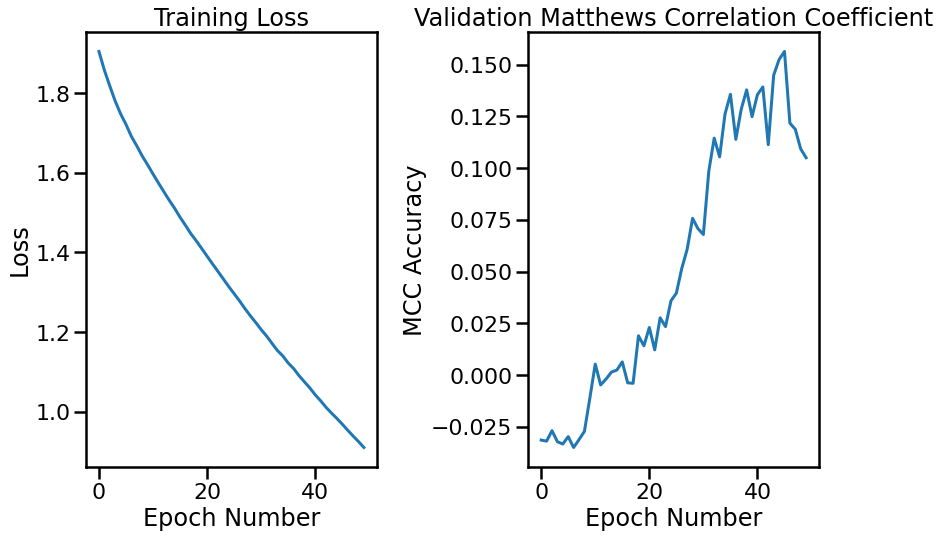

In [299]:
fig = plt.figure(figsize=(12, 8),constrained_layout=True)
ax = fig.add_subplot(121)
sn.lineplot(data=final_result, x='epoch', y='loss',
            ax=ax)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")


ax = fig.add_subplot(122)
sn.lineplot(data=final_result, x='epoch', y='accuracy',
            ax=ax)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("MCC Accuracy")
ax.set_title("Validation Matthews Correlation Coefficient")
plt.tight_layout()
plt.show()

## Model evaluation. (ignore for now)

In [ ]:
torch.save(model, 'toymodel_v1.pth')

In [122]:
a = torch.nn.functional.softmax(out[:,-1], dim=1)
a
model.eval()
test_output = model(test_X)
test_output

tensor([[[12.5032, 12.6446, 12.3077,  ..., 13.5077, 11.9308, 11.4618],
         [11.6565, 11.6720, 11.4045,  ..., 12.4632, 10.9850, 10.3595],
         [ 8.1789,  8.2931,  8.0786,  ...,  8.8105,  7.6705,  6.8414],
         ...,
         [ 1.1780,  0.8500,  0.6075,  ...,  2.0327,  1.2092,  0.9339],
         [ 1.2660,  0.9534,  0.6894,  ...,  2.1376,  1.3011,  1.0296],
         [ 1.2974,  1.0200,  0.6692,  ...,  2.1922,  1.3423,  1.0890]],

        [[12.4804, 12.6548, 12.2693,  ..., 13.4732, 11.9620, 11.4532],
         [11.6806, 11.7929, 11.3983,  ..., 12.5062, 11.1315, 10.4556],
         [ 8.3648,  8.4979,  8.1861,  ...,  8.8866,  8.0394,  7.0448],
         ...,
         [ 1.1475,  0.8494,  0.9151,  ...,  1.9597,  1.2745,  1.0364],
         [ 1.1268,  0.8246,  0.8618,  ...,  1.9234,  1.2332,  1.0172],
         [ 1.0500,  0.7694,  0.7601,  ...,  1.8594,  1.1531,  0.9487]],

        [[12.4667, 12.6237, 12.2617,  ..., 13.4511, 11.9527, 11.4342],
         [11.7167, 11.8071, 11.4359,  ..., 12